In [11]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import random

DATA_DIR = 'results_003_lang_id_classification/'

COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
random.seed(42)
random.shuffle(COLORS)
#COLORS = ["#7f7f7f", "#1f77b4"]


n = 84
n_train = int(np.ceil(n * .6))
n_test = n - n_train


In [12]:
data_frames = {}

for model_path in Path(DATA_DIR).iterdir():
    if not model_path.is_dir():
        continue
    
    data_frames[model_path.stem] = {}
    
    for p in Path(model_path).iterdir():
        if p.suffixes[-1] != '.csv':
            continue

        data_frames[model_path.stem][p.stem] = pd.read_csv(p)

In [13]:
def get_variable_stats(model_name, feature_prefix, variable, sample_size):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    data = np.zeros((epoch_count, experiment_count))
    
    for index, df in enumerate(selected_dfs):
        data[:, index] = df[variable]
    
    m = np.mean(data, axis=1)
    sem = np.std(data, axis=1) / np.sqrt(sample_size)
    
    return data, m, sem
    
        

In [14]:
def plot_comparative_variables(ax, model_name, feature_prefixes, variable, sample_size, color):
    line_styles = ['-', ':']
    for index, feature_prefix in enumerate(feature_prefixes):
        data, m, sem = get_variable_stats(model_name, feature_prefix, variable, sample_size)
        x = range(1, data.shape[0]+1)

        ax.plot(x, m, color=color, linestyle=line_styles[index], label=f'{model_name} {feature_prefix}')
        ax.fill_between(x, m+sem, m-sem, color=color, alpha=0.1)

    ax.grid(True)
    ax.title.set_text(variable)
    ax.legend()

# Language classification with context features

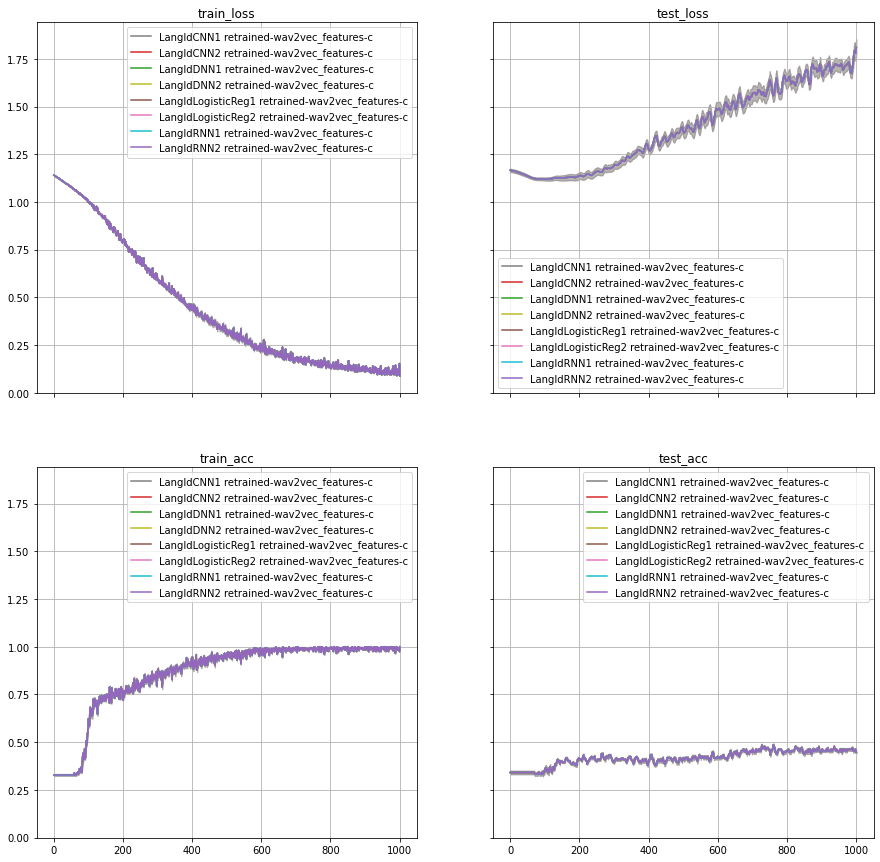

In [24]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15, 15))
sample_sizes = [n_train, n_test, n_train, n_test]
for model_index, model_name in enumerate(sorted(data_frames.keys())):
    for index, variable in enumerate(['train_loss','test_loss','train_acc','test_acc']):
        #plt.subplot(2, 2, index+1, sharex=True, sharey=True)
        r = int(index/2)
        c = index%2
        sample_size = sample_sizes[index]
        plot_comparative_variables(
            axes[r, c],
            model_name,
            ['retrained-wav2vec_features-c'], # ['wav2vec_features-c', 'retrained-wav2vec_features-c'],
            variable,
            sample_size,
            color = COLORS[model_index]
        )
    

# Language Classification With Latent Features

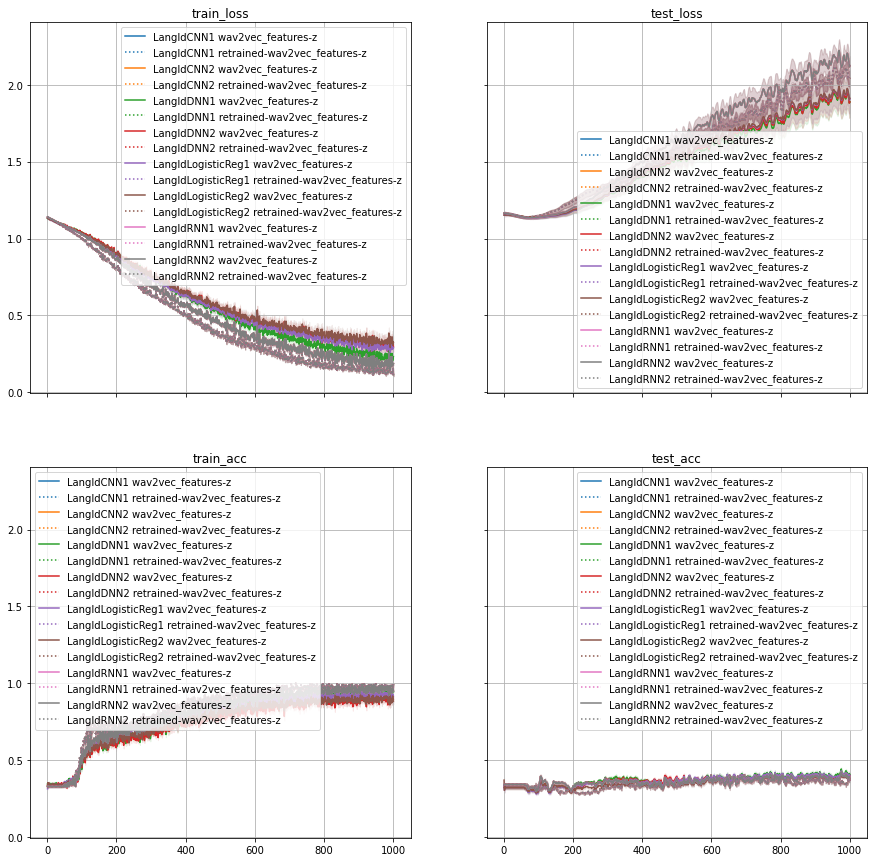

In [9]:
sample_sizes = [n_train, n_test, n_train, n_test]
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15, 15))
for model_index, model_name in enumerate(sorted(data_frames.keys())):
    for index, variable in enumerate(['train_loss','test_loss','train_acc','test_acc']):
        #plt.subplot(2, 2, index+1, sharex=True, sharey=True)
        r = int(index/2)
        c = index%2
        sample_size = sample_sizes[index]
        plot_comparative_variables(
            axes[r, c],
            model_name,
            ['wav2vec_features-z', 'retrained-wav2vec_features-z'],
            variable,
            sample_size,
            COLORS[model_index]
        )
    